In [157]:
import tabula
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import sklearn.tree
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


In [158]:
def Matriculas(Dat, year):
    Aux = Dat.loc[Dat.index==year] # Selects only data for given
    Matricula = Aux.loc[Aux['Programa']!='Total'].fillna(0).reset_index()
    return Matricula

In [159]:
#+++++++++++++++++++++++ Número de inscritos, admitidos y estudiantes +++++++++++++++++++++++#
#+++++++++++++++++++++++    matriculados por programa de pregrado     +++++++++++++++++++++++#

# Take index_col=2 since col 2 has the sample periods and thus is more easy data filtering.
Data = pd.read_csv('T15_Sup_Est_2021-I.csv', index_col=2, encoding='latin-1') # Table 15 is in pages 32 - 36.

Matricula_2017_1 = Matriculas(Data, '2017-1')
Matricula_2017_2 = Matriculas(Data, '2017-2')
Matricula_2018_1 = Matriculas(Data, '2018-1')
Matricula_2018_2 = Matriculas(Data, '2018-2')
Matricula_2019_1 = Matriculas(Data, '2019-1')
Matricula_2019_2 = Matriculas(Data, '2019-2')
Matricula_2020_1 = Matriculas(Data, '2020-1')
Matricula_2020_2 = Matriculas(Data, '2020-2')
Matricula_2021_1 = Matriculas(Data, '2021-1')

In [160]:
data = Matricula_2017_1
year = '2017-1'
depmax = 4
reg_type = 'absolute_error'
cv_splits = 10 # Must be less than sample number
test = Matricula_2021_1

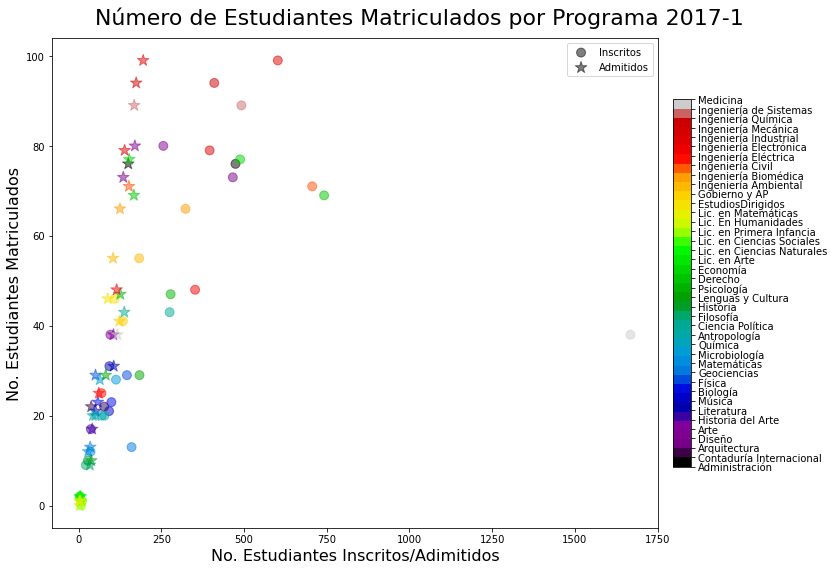

In [161]:
plt.rcParams["figure.figsize"] = [12, 8]

# setup the normalization and the colormap
deps = np.arange(0, len(data['Programa']))
normalize = mcolors.Normalize(vmin = deps.min(), vmax = deps.max())
colormap = cm.get_cmap('nipy_spectral', deps.max()+1)
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(deps)

fig = plt.figure()

fig.suptitle('Número de Estudiantes Matriculados por Programa '+str(year), size=22)
plt.xlabel('No. Estudiantes Inscritos/Adimitidos',  fontsize=16)
plt.ylabel('No. Estudiantes Matriculados',  fontsize=16)

plt.scatter(data['Inscritos (1ra Opción)'], data['Matriculados'], label='Inscritos',
            alpha=0.5, s=80, c=range(0, len(data)), cmap='nipy_spectral')
plt.scatter(data['Admitidos (1ra y 2da Opción)'], data['Matriculados'], label='Admitidos',
            alpha=0.5, marker='*', s=150, c=range(0, len(data)), cmap='nipy_spectral')
plt.legend()

cbar = plt.colorbar(scalarmappaple, orientation='vertical', pad=0.02,
                   ticks=range(0, deps.max()+1, 1), shrink=0.75)
cbar.ax.set_yticklabels(data['Programa'])

plt.subplots_adjust(left=0.075, bottom=0.075, right=0.92, top=0.925)
plt.show()
fig.savefig('Matriculados_'+str(year)+'.pdf', dpi=500)
plt.close(fig)

13.9625 5.02402042690911
10.4625 5.945074116442957
9.5125 6.180222993549667
9.75 6.248249754931376
9.0125 4.815161601649523
9.3 6.108191221630181
9.35 6.204030947698439
8.85 5.000249993750312
8.925 5.9666259309596406
8.975 5.852830511812211
9.3 6.147967143698802
9.65 6.3876834611618
9.275 6.286344327190485


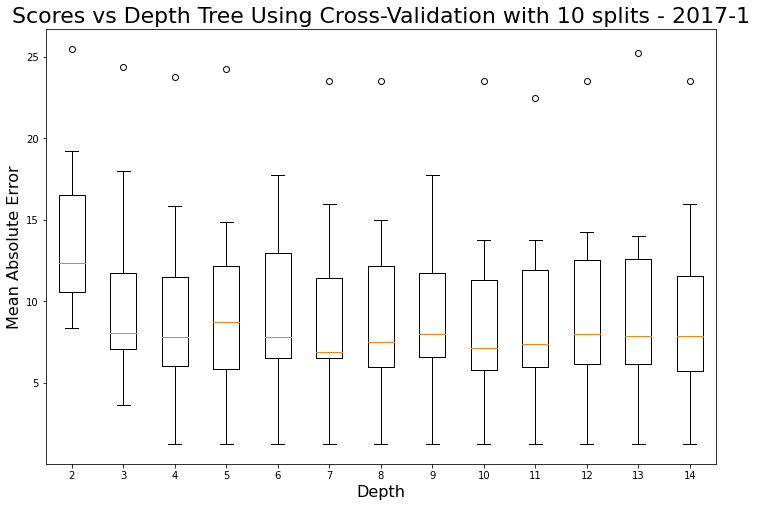

In [162]:
Scores = []
Deeps = []

for deeps in range(2, 15):
    regs = DecisionTreeRegressor(max_depth=deeps, criterion=reg_type)
    scs = -cross_val_score(regs,
                           data[['Inscritos (1ra Opción)', 'Admitidos (1ra y 2da Opción)']],
                           data['Matriculados'],
                           scoring='neg_mean_absolute_error',
                           cv=cv_splits)
    Scores.append(scs)
    Deeps.append(deeps)
    print(scs.mean(), scs.std())

fig = plt.figure()
plt.boxplot(Scores, labels=Deeps)
plt.title('Scores vs Depth Tree Using Cross-Validation with '+str(cv_splits)+' splits - '+str(year), size=22)
plt.xlabel('Depth', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=16)
plt.show()
fig.savefig('Scores_Splits_'+str(cv_splits)+'_'+str(year)+'.pdf', dpi=500)
plt.close(fig)

In [163]:
regressor = DecisionTreeRegressor(max_depth=depmax, criterion=reg_type)

regressor.fit(data[['Inscritos (1ra Opción)', 'Admitidos (1ra y 2da Opción)']],
              data['Matriculados'])

#DecisionTreeRegressor(criterion='mse',
#                      max_depth=2,
#                      max_features=None,
#                      max_leaf_nodes=None,
#                      min_samples_leaf=1,
#                      min_samples_split=2,
#                      min_weight_fraction_leaf=0.0,
#                      presort=False,
#                      random_state=None,
#                      splitter='best')

scores = -cross_val_score(regressor,
                          data[['Inscritos (1ra Opción)', 'Admitidos (1ra y 2da Opción)']],
                          data['Matriculados'],
                          scoring='neg_mean_absolute_error', cv=cv_splits)

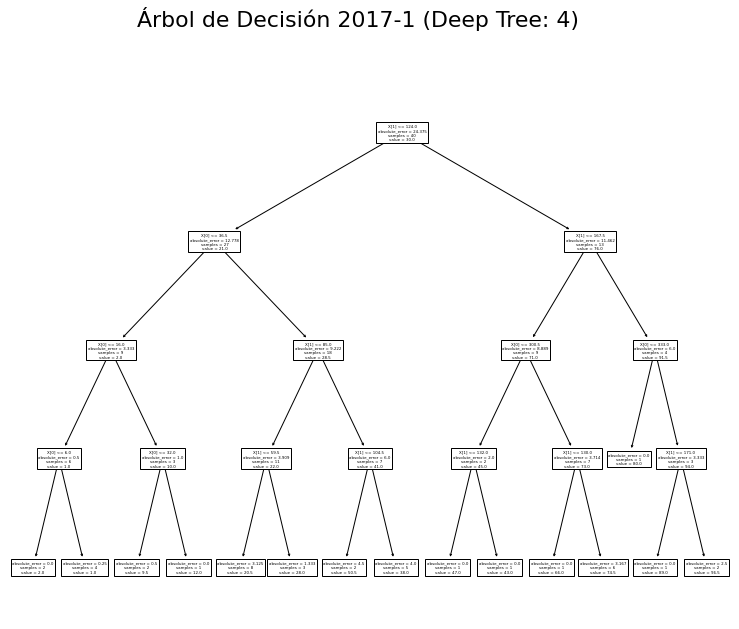

In [164]:
fig = plt.figure(figsize=(13, 10))
fig.suptitle('Árbol de Decisión '+str(year)+' (Deep Tree: '+str(depmax)+')', size=22)
_= sklearn.tree.plot_tree(regressor)
plt.show()
fig.savefig('Tree_'+str(year)+'.pdf', dpi=500)
plt.close(fig)

In [165]:
Ins_max = max(data['Inscritos (1ra Opción)'])
Adm_max = max(data['Admitidos (1ra y 2da Opción)'])
Ins_min = min(data['Inscritos (1ra Opción)'])
Adm_min = min(data['Admitidos (1ra y 2da Opción)'])

N = len(data)

Ins_Test = np.linspace(Ins_min, Ins_max, N)
Adm_Test = np.linspace(Adm_min, Adm_max, N)

xx, yy = np.meshgrid(Ins_Test, Adm_Test)

Mat_Predtc = regressor.predict(np.array([xx.flatten(), yy.flatten()]).T)

zz = np.reshape(Mat_Predtc, (N, N))

/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


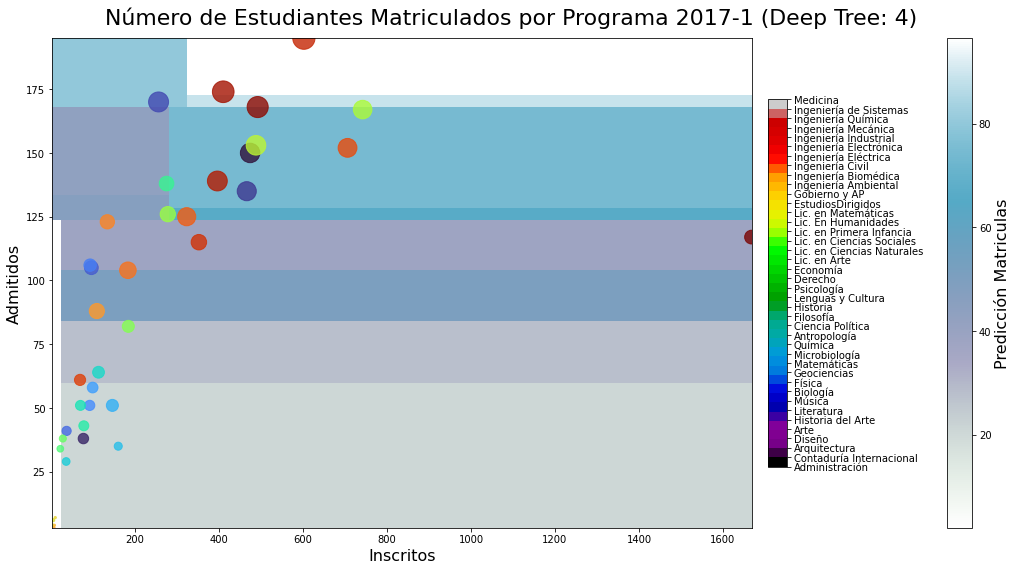

In [166]:
plt.rcParams["figure.figsize"] = [15, 8]

cmap = plt.cm.ocean#Reds#RdBu
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

fig = plt.figure()

fig.suptitle('Número de Estudiantes Matriculados por Programa '+str(year)+' (Deep Tree: '+str(depmax)+')',
             size=22)
plt.xlabel('Inscritos', fontsize=16)
plt.ylabel('Admitidos', fontsize=16)

# setting the limit for each axis
plt.xlim(Ins_min, Ins_max)
plt.ylim(Adm_min, Adm_max)

# plotting the predictions
plt.pcolormesh(Ins_Test, Adm_Test, zz, cmap=my_cmap)
cb = plt.colorbar(label='Predicción Matriculas') # add a colorbar on the right
cb.set_label('Predicción Matriculas', size=16,)
# plotting also the observations
plt.scatter(data['Inscritos (1ra Opción)'], data['Admitidos (1ra y 2da Opción)'],
            alpha=0.8, s=5*data['Matriculados'],
            c=range(0, len(data)), cmap='turbo')

cbar = plt.colorbar(scalarmappaple, orientation='vertical', pad=0.02,
                   ticks=range(0, deps.max()+1, 1), shrink=0.75)
cbar.ax.set_yticklabels(data['Programa'])

plt.subplots_adjust(left=0.075, bottom=0.075, right=1.05, top=0.925)
plt.show()
fig.savefig('Predicciones_'+str(year)+'.pdf', dpi=500)
plt.close(fig)

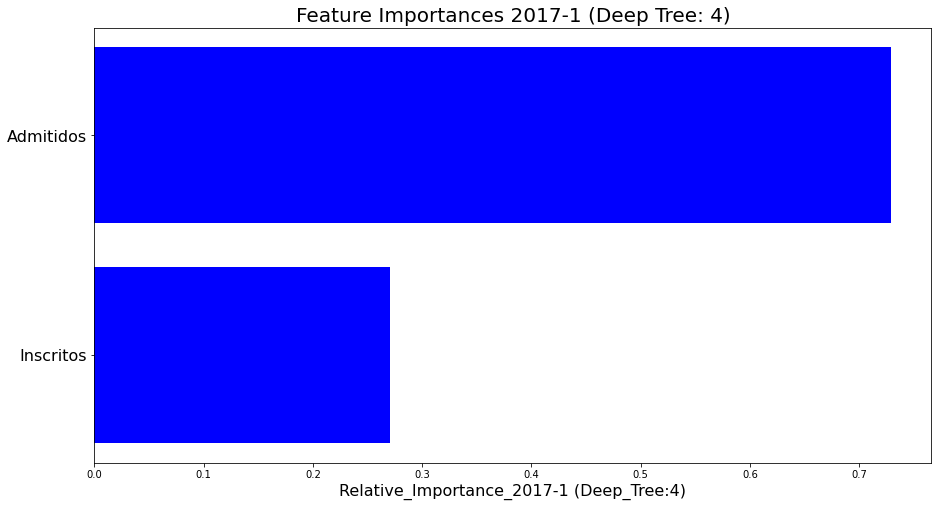

In [167]:
Importances = regressor.feature_importances_

Features = ['Inscritos', 'Admitidos']
Indices = np.argsort(Importances)

fig = plt.figure()
plt.title('Feature Importances '+str(year)+' (Deep Tree: '+str(depmax)+')', fontsize=20)
plt.barh(range(len(Indices)), Importances[Indices], color='b', align='center')
plt.yticks(range(len(Indices)), [Features[i] for i in Indices], fontsize=16)
plt.xlabel('Relative_Importance_'+str(year)+' (Deep_Tree:'+str(depmax)+')', fontsize=16)
plt.show()
fig.savefig('Importances_'+str(year)+'.pdf', dpi=500)
plt.close(fig)

In [168]:
X1_Test = np.array(test['Inscritos (1ra Opción)'])
X2_Test = np.array(test['Admitidos (1ra y 2da Opción)'])

Y_real = np.array(test['Matriculados'])
Y_Pred = []

for i in range(len(test)):
    y0 = regressor.predict(np.array([[X1_Test[i], X2_Test[i]]]))
    Y_Pred.append(y0[0])

Y_diff = np.abs(Y_real - Y_Pred)#/np.array(Y_real)

/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/skle

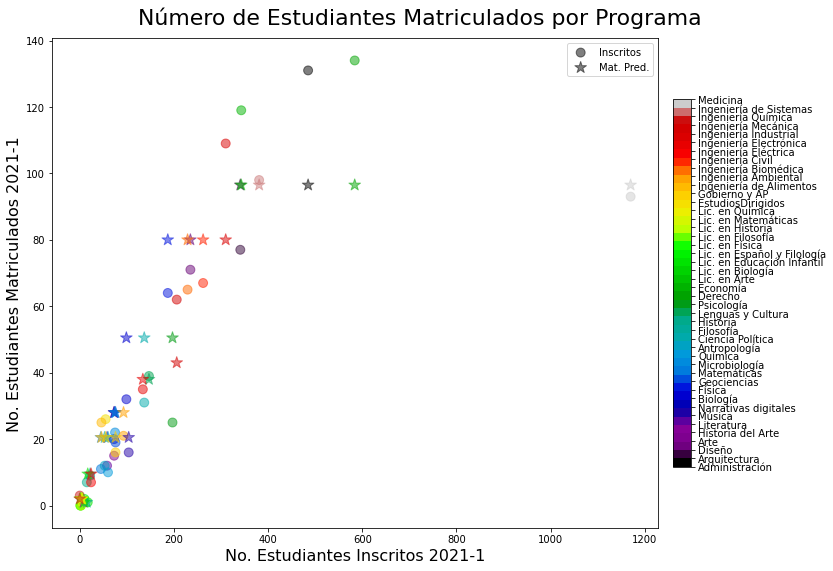

In [169]:
plt.rcParams["figure.figsize"] = [12, 8]

# setup the normalization and the colormap
deps = np.arange(0, len(test['Programa']))
normalize = mcolors.Normalize(vmin = deps.min(), vmax = deps.max())
colormap = cm.get_cmap('nipy_spectral', deps.max()+1)
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(deps)

fig = plt.figure()

fig.suptitle('Número de Estudiantes Matriculados por Programa', size=22)
plt.xlabel('No. Estudiantes Inscritos 2021-1',  fontsize=16)
plt.ylabel('No. Estudiantes Matriculados 2021-1',  fontsize=16)

plt.scatter(X1_Test, Y_real, label='Inscritos',
            alpha=0.5, s=80, c=range(0, len(test)), cmap='nipy_spectral')
plt.scatter(X1_Test, Y_Pred, label='Mat. Pred.',
            alpha=0.5, marker='*', s=150, c=range(0, len(test)), cmap='nipy_spectral')
plt.legend()

cbar = plt.colorbar(scalarmappaple, orientation='vertical', pad=0.02,
                   ticks=range(0, deps.max()+1, 1), shrink=0.75)
cbar.ax.set_yticklabels(test['Programa'])

plt.subplots_adjust(left=0.075, bottom=0.075, right=0.92, top=0.925)
plt.show()
fig.savefig('2021-1_Matriculados_por_Ins_'+str(year)+'.pdf', dpi=500)
plt.close(fig)

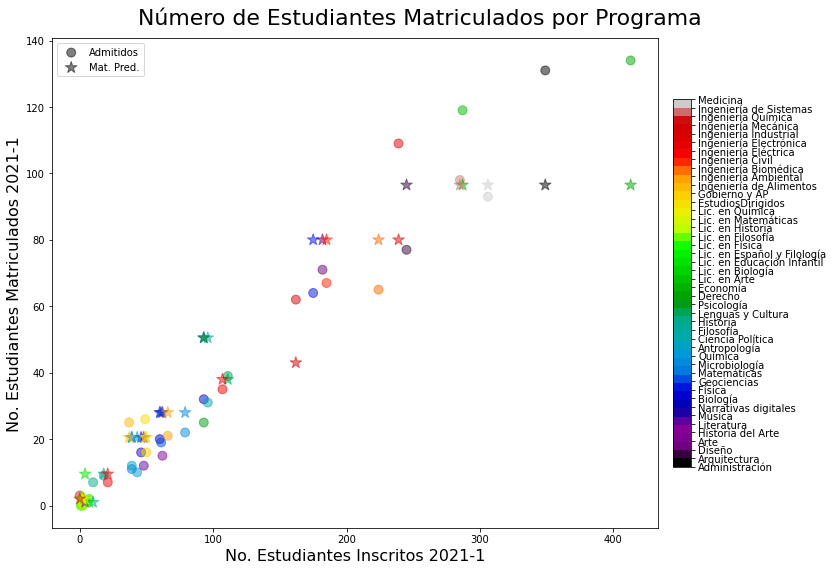

In [170]:
plt.rcParams["figure.figsize"] = [12, 8]

# setup the normalization and the colormap
deps = np.arange(0, len(test['Programa']))
normalize = mcolors.Normalize(vmin = deps.min(), vmax = deps.max())
colormap = cm.get_cmap('nipy_spectral', deps.max()+1)
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(deps)

fig = plt.figure()

fig.suptitle('Número de Estudiantes Matriculados por Programa', size=22)
plt.xlabel('No. Estudiantes Inscritos 2021-1',  fontsize=16)
plt.ylabel('No. Estudiantes Matriculados 2021-1',  fontsize=16)

plt.scatter(X2_Test, Y_real, label='Admitidos',
            alpha=0.5, s=80, c=range(0, len(test)), cmap='nipy_spectral')
plt.scatter(X2_Test, Y_Pred, label='Mat. Pred.',
            alpha=0.5, marker='*', s=150, c=range(0, len(test)), cmap='nipy_spectral')
plt.legend()

cbar = plt.colorbar(scalarmappaple, orientation='vertical', pad=0.02,
                   ticks=range(0, deps.max()+1, 1), shrink=0.75)
cbar.ax.set_yticklabels(test['Programa'])

plt.subplots_adjust(left=0.075, bottom=0.075, right=0.92, top=0.925)
plt.show()
fig.savefig('2021-1_Matriculados_por_Adm_'+str(year)+'.pdf', dpi=500)
plt.close(fig)